# Clustering

In [296]:
import math
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import datetime

from collections import defaultdict
from scipy.stats.stats import pearsonr


df = pd.read_csv(r"./data/training_ready_no_regression.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57863 entries, 0 to 57862
Data columns (total 29 columns):
RefId                                57863 non-null int64
IsBadBuy                             57863 non-null int64
PurchDate                            57863 non-null object
Auction                              57863 non-null object
VehicleAge                           57863 non-null int64
Make                                 57863 non-null object
Model                                57863 non-null object
Trim                                 57863 non-null object
SubModel                             57863 non-null object
Color                                57863 non-null object
Transmission                         57863 non-null object
WheelType                            57863 non-null object
VehOdo                               57863 non-null int64
Nationality                          57863 non-null object
Size                                 57863 non-null object
TopThreeAm

## Selezione e manipolazione attributi

Elimino i record con almeno un elemento Nan (non dovrebbero esserci in teoria perchè il dataset è uscito dalla fase di data preparation)

In [297]:
df.isnull().sum()

RefId                                0
IsBadBuy                             0
PurchDate                            0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
WheelType                            0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
VNST                                 0
VehBCost                 

Dato che il Clustering non può essere applicato agli attributi categorici, dobibamo selezionare solo quelli numerici.

In [298]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.copy(deep=True).select_dtypes(include=numerics)
del df_num['RefId']
del df_num['IsOnlineSale']
del df_num['VehicleAge']
df_num.head()

,IsBadBuy,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
0,1,61184,6796.0,7555.0,10140.0,10805.0,6628.0,7535.0,9605.0,10650.0,6100.0,533
1,0,92383,5480.0,6461.0,6418.0,7478.0,5480.0,6461.0,6418.0,7478.0,4000.0,1630
2,0,45965,8067.0,8580.0,11073.0,11652.0,7497.0,8102.0,10721.0,11350.0,7500.0,693
3,0,80169,4817.0,6658.0,5702.0,7691.0,4817.0,6658.0,5702.0,7691.0,4725.0,1633
4,0,77372,5430.0,6633.0,6364.0,7664.0,5370.0,6811.0,6300.0,7856.0,5670.0,1623


## Preprocessing dei dati: scelta degli attributi

In [299]:
corr_mat = df_num.corr(method='pearson') 
corr_mat.style.background_gradient(cmap='coolwarm')

,IsBadBuy,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
IsBadBuy,1,0.0838483,-0.113623,-0.107306,-0.0914413,-0.0880172,-0.11294,-0.108007,-0.107617,-0.104422,-0.104214,0.0488535
VehOdo,0.0838483,1,-0.0158113,0.0284938,0.0330991,0.0677801,-0.0280098,0.0142455,0.0165085,0.050431,-0.0622476,0.41226
MMRAcquisitionAuctionAveragePrice,-0.113623,-0.0158113,1,0.98964,0.903104,0.902898,0.953325,0.947315,0.886466,0.885431,0.822264,-0.0486511
MMRAcquisitionAuctionCleanPrice,-0.107306,0.0284938,0.98964,1,0.893439,0.910187,0.941327,0.950071,0.876976,0.887915,0.819467,-0.0168614
MMRAcquisitionRetailAveragePrice,-0.0914413,0.0330991,0.903104,0.893439,1,0.989379,0.864323,0.860678,0.932802,0.924688,0.782094,-0.0530946
MMRAcquisitonRetailCleanPrice,-0.0880172,0.0677801,0.902898,0.910187,0.989379,1,0.862105,0.870244,0.925248,0.928471,0.7869,-0.0246709
MMRCurrentAuctionAveragePrice,-0.11294,-0.0280098,0.953325,0.941327,0.864323,0.862105,1,0.989893,0.911257,0.908556,0.795352,-0.0530429
MMRCurrentAuctionCleanPrice,-0.108007,0.0142455,0.947315,0.950071,0.860678,0.870244,0.989893,1,0.903487,0.917289,0.794936,-0.0230829
MMRCurrentRetailAveragePrice,-0.107617,0.0165085,0.886466,0.876976,0.932802,0.925248,0.911257,0.903487,1,0.989199,0.77855,-0.055052
MMRCurrentRetailCleanPrice,-0.104422,0.050431,0.885431,0.887915,0.924688,0.928471,0.908556,0.917289,0.989199,1,0.781859,-0.0276851


In [300]:
del df_num['MMRAcquisitionAuctionCleanPrice']
del df_num['MMRAcquisitionRetailAveragePrice']
del df_num['MMRAcquisitonRetailCleanPrice']
del df_num['MMRCurrentAuctionAveragePrice']
del df_num['MMRCurrentAuctionCleanPrice']
del df_num['MMRCurrentRetailAveragePrice']
del df_num['MMRCurrentRetailCleanPrice']

In [301]:
#df_num['MMRAAP']=df_num['MMRAcquisitionAuctionAveragePrice']
del df_num['MMRAcquisitionAuctionAveragePrice']

Tengo solo __MMRAcquisitionAuctionAveragePrice__.

In [302]:
from pandas.plotting import scatter_matrix

classes = df_num['IsBadBuy']
del df_num['IsBadBuy']

columns = df_num.columns

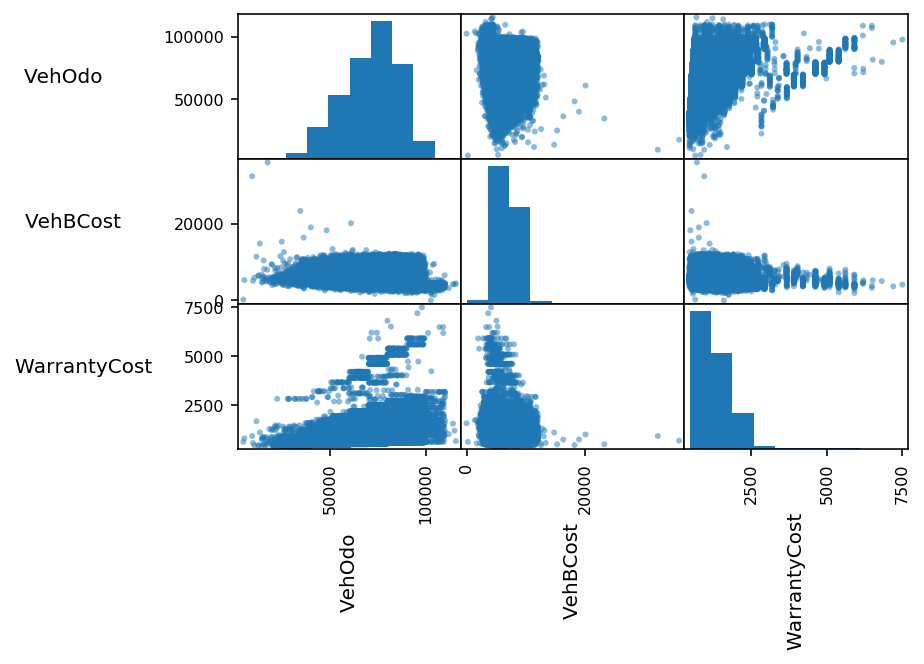

In [303]:
axs = scatter_matrix(df_num[columns])
n = len(columns)


for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
plt.show()

Ora eliminiamo gli outlier. Fonte: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [304]:
tot = df_num.shape[0]
# identify outliers with interquartile range
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
k = 1.35
df_num = df_num[~((df_num < (Q1 - (k * IQR))) | (df_num > (Q3 + (k * IQR)))).any(axis=1)]
tot_no_outlier = df_num.shape[0]

print('Outlier removed: '+str(tot-tot_no_outlier))

Outlier removed: 1568


Come abbiamo osservato nella fase di data understanding, il nostro dataset è sbilanciato e la maggior parte dei record ha __IsBadBuy__ == 1

In [305]:
zeros = np.round((100*df['IsBadBuy'].value_counts()[0])/df.shape[0], decimals=2)
ones = np.round((100*df['IsBadBuy'].value_counts()[1])/df.shape[0], decimals=2)

print("0s: "+str(zeros)+"%")
print("1s: "+str(ones)+"%")

0s: 87.72%
1s: 12.28%


Utilizzo la tecnica dell' undersampling sulla classe maggioritaria, fonte: https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data.

In [306]:
#from sklearn.utils import resample


#good_buy_undersamp =  resample(good_buy,
#                                replace = False, # sample without replacement
#                                n_samples = len(bad_buy), # match minority n
#                                random_state = 42) # reproducible results

#df_us = pd.concat([good_buy_undersamp, bad_buy])
#df_us.IsBadBuy.value_counts()

Rimuoviamo la classe dal dataset perchè il clustering è un task non supervisionato

In [307]:
#df_us.info()

## Preprocessamento dei dati: normalizzazione
Una buona pratica nel clustering per evitare il bias dato dai differenti range degli attributi è la normalizzazione.
Le normalizzazioni più usate sono: Z-Score e Min-Max

In [308]:
from sklearn.preprocessing import MinMaxScaler

In [309]:
scaler = MinMaxScaler()
scaler.fit(df_num.head().values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [310]:
df_num.head().values

array([[61184.,  6100.,   533.],
       [92383.,  4000.,  1630.],
       [45965.,  7500.,   693.],
       [80169.,  4725.,  1633.],
       [77372.,  5670.,  1623.]])

In [311]:
scaler.transform(df_num.head().values)

array([[0.3278685 , 0.6       , 0.        ],
       [1.        , 0.        , 0.99727273],
       [0.        , 1.        , 0.14545455],
       [0.73686932, 0.20714286, 1.        ],
       [0.67661252, 0.47714286, 0.99090909]])

In [312]:
scaler.inverse_transform(scaler.transform(df_num.head().values))

array([[61184.,  6100.,   533.],
       [92383.,  4000.,  1630.],
       [45965.,  7500.,   693.],
       [80169.,  4725.,  1633.],
       [77372.,  5670.,  1623.]])

In [313]:
X = scaler.fit_transform(df_num.values)

## K-Means

In [314]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Usiamo il metodo di Knee per stimare il miglior k

In [315]:
sse_list = list()
max_k = 8
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=15, max_iter=200)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

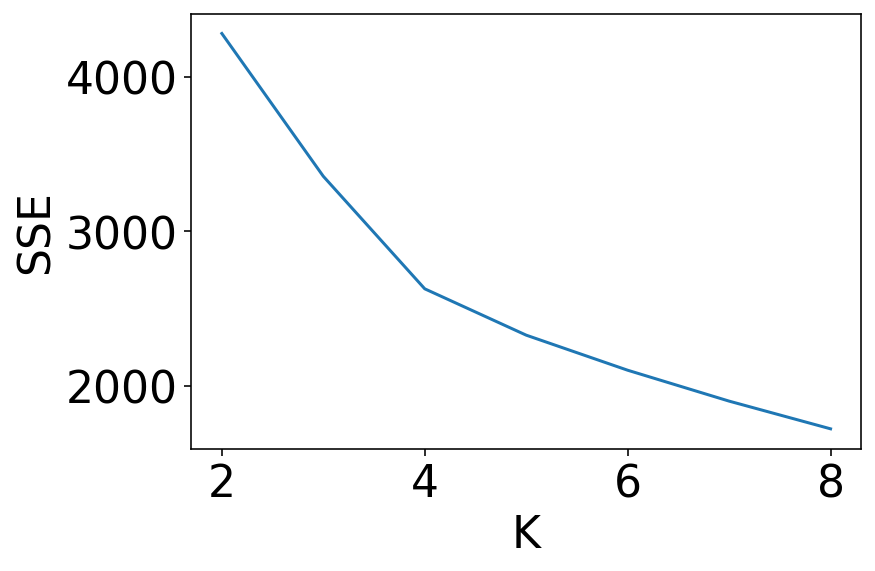

In [316]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [317]:
kmeans = KMeans(n_clusters=4, n_init=15, max_iter=200)
kmeans.fit(X)
X.shape

(56295, 3)

In [318]:
kmeans.labels_[:5]

array([1, 2, 1, 2, 0], dtype=int32)

In [319]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([13158, 15211, 14267, 13659]))

In [320]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 13158, 1: 15211, 2: 14267, 3: 13659}

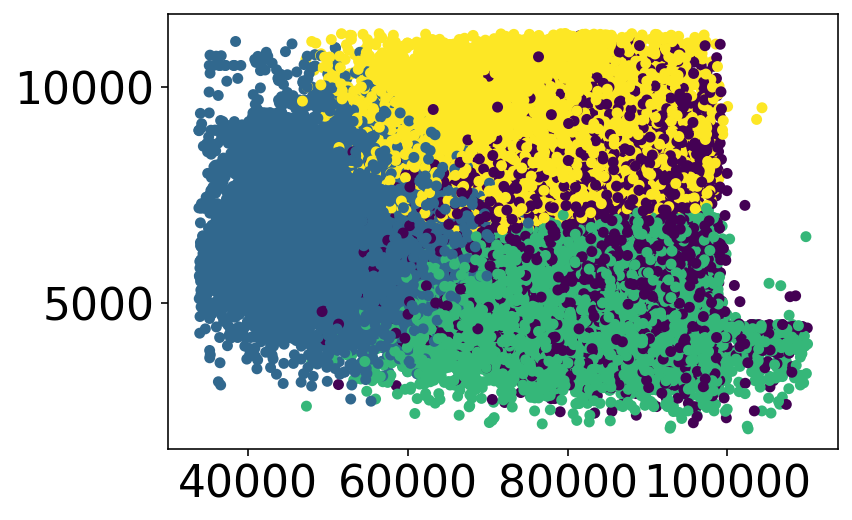

In [321]:
plt.scatter(df_num['VehOdo'], df_num['VehBCost'], 
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [50]:
print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

SSE 1.9749978527812562e+18
